# Housing Data Analysis with Linear Regression

## Overview

For this project I'll be using the Kings County housing dataset to solve a housing-related business problem using linear regression techniques.
I'll be using the CRISP-DM Data Science method which the structure this notebook will follow, demonstraing an iterative modeling process with feature engineering, model fit, evaluation, and repeating until the model proves to be useful to my business case. 

<img src="Images/new_crisp-dm.png" width=400>

## Business Understanding

A housing development company is working on new model homes. They want to design houses that will sell to middle class buyers who are currently facing a shortage of available and affordable inventory due to the increase in demand during 2020.

The median national home listing price grew by 13.4% over last year nationally, and The Seattle-Tacoma-Bellevue metro area saw YoY listing prices rise 7.8% with a median price of $627,500. Meanwhile, there was a 35.6% decrease in listings. So less houses available and higher prices. 

The developers would like understand which features a home should include at the median price range so that they can appropriately design new homes to replenish inventory and make some sales where they know demand exists.

source: https://www.realtor.com/research/december-2020-data/

## Data Understanding

This data includes house sale prices and conditions from houses sold through 2014-2015 in the Seattle area. These houses were built as early as 1900 and as late as 2015. The data includes several variables that describe the house, its location, and its condition. 

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

I'm going to start by importing all my libraries and loading the data into a dataframe.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [84]:
data = pd.read_csv('data/kc_house_data.csv')
# data.info()
# data.describe()

### Defining My Target

Knowing that my stakeholders are aiming to sell to buyers that are looking within a certain price range, I'll have to define a range of the data I am using for my model. By examining the distribution of values, I can see there are outliers on the higher end that could skew my model by including all these houses that go up to $7MM sale prices. 

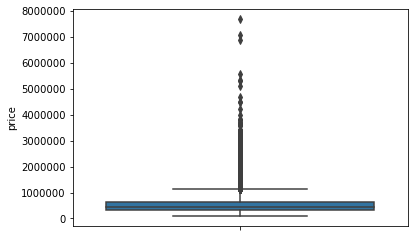

In [85]:
sns.boxplot(data['price'], orient='v')

In [86]:
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

All the outliers are on the higher end, skewing the data. Since the 75% bound is close to the median price in 2020, I'm going to redefine the data to 2 standard deviations above and below that.

In [87]:
y_range = ((data['price'].std()*2) - 645000), (645000 + (data['price'].std()*2))
y_range

(89736.280202789, 1379736.280202789)

In [88]:
new_data = data[data['price'].between(y_range[0], y_range[1])]

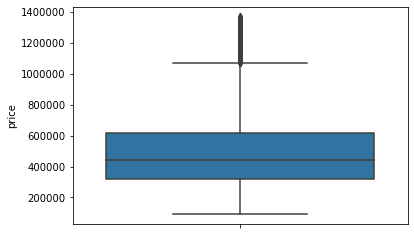

In [89]:
sns.boxplot(new_data['price'], orient='v')

Even with that, there are still a lot of outliers so I am going to filter out the outliers outside the upper bound of the boxplot.

In [90]:
new_data = new_data.loc[new_data['price'] <= 1150000]

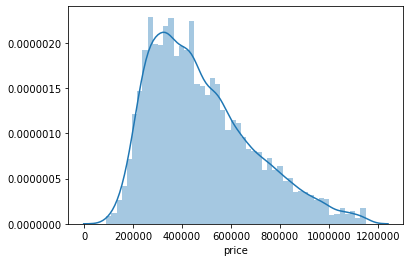

In [91]:
sns.distplot(new_data['price'])

In [92]:
new_data['price'].describe()

count    2.050200e+04
mean     4.793161e+05
std      2.110772e+05
min      8.995000e+04
25%      3.150000e+05
50%      4.390000e+05
75%      6.050000e+05
max      1.150000e+06
Name: price, dtype: float64

In [93]:
(data.shape[0] - new_data.shape[0])/ data.shape[0]

0.050701486317544106

That filtering only eliminated 5% of the original data so there is still a significant amount to work with. The data now falls within a realistic range for my potential buyer, but the mean is a bit lower than the median market price I referenced earlier. Looking at the distribution of the data again, it's really skewed toward the lower end. I'll keep this in mind when running model analyses. 

## Data Preparation

### Data Cleaning
To prepare my data to fit to a model, I'll have to clean out anything the model can't read or that is clearly innacurate/irrelevant. Previewing the data I can see there are some null values I'll have to deal with. These are coming from year renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely.

For Waterfront and View:

 - There are only 146 houses that are coded as waterfront. I don't want to drop nulls because there are over 2K, so I am going to fill the null values with 0 since it won't affect the distribution much.
 
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature since I am building new houses, not selling ones that are on the market. I am going to fill these nulls with a 0 assuming they were not available to view, but I am not going to include this feature for now.


In [94]:
new_data['waterfront'].fillna(0.0, inplace=True)
new_data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [95]:
new_data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
new_data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in new_data.index:
    if new_data['yr_renovated'][row] != 0.0:
        new_data['is_renovated'][row] = 1

Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [96]:
#use lambda function to replace all the symbols, and then make sure the column is read as on integer
new_data['sqft_basement'] = new_data['sqft_basement'].map(lambda x: x.replace("?", "0"))
new_data['sqft_basement'] = pd.to_numeric(new_data['sqft_basement'], downcast='integer')

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that costs only $640k.

In [97]:
new_data[new_data.bedrooms == new_data.bedrooms.max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0


In [98]:
new_data = new_data.drop([15856], axis=0)

### Preprocessing

Now I am going to examine the data to see how it will need to be processed to fit to a model. 

First I'm going to separate my continuous from categorical columns so I can treat each type appropriately. I am excluding ID, date and the sqft 15 columns. The dates are all from the same 2 years so there isn't a diverse amount of data - it basically just tells me that all these houses were sold. The neighboring house info is not relevant since my stakeholders are working on a new development for which they'll design neighboring houses.

I'm separating out latitude and longitude since they are technically continuous but can't be treated the same way as other continuous variables.

In [99]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
geo_cols= ['lat', 'long']
y = new_data['price']
X_cols = new_data[cat_cols + con_cols + geo_cols]

Then I'm going to run a few visual techniques to take a look at my data and see what features I may need to address for modeling. First, I'm running pair plots to see if there's any obvious correlations between the X variables and y that can be seen visually.

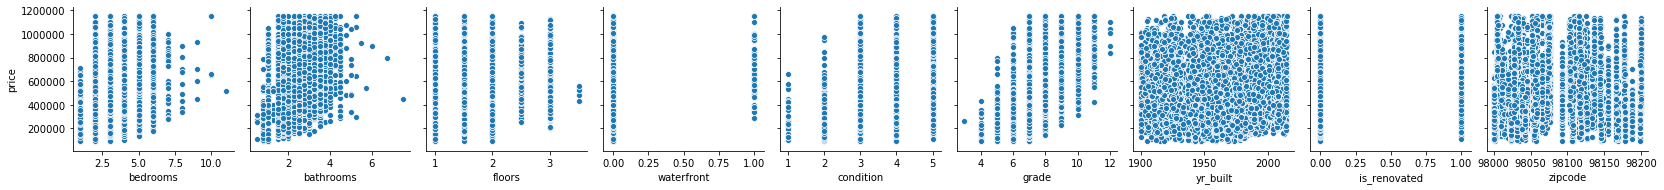

In [100]:
sns.pairplot(
    new_data,
    x_vars=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'is_renovated', 'zipcode'],
    y_vars=['price'])

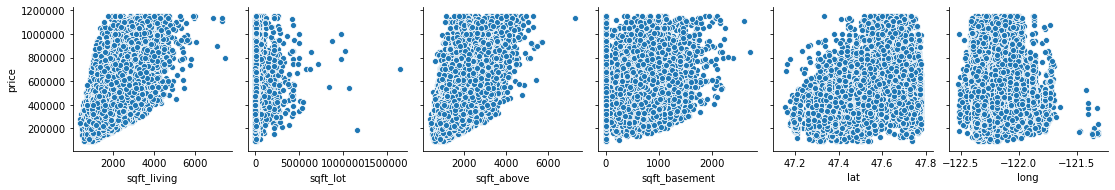

In [101]:
sns.pairplot(
    new_data,
    x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long'],
    y_vars=['price'])

From the categoricals, grade seems to be the only one tht somewhat affects price. Bedrooms and bathrooms appear to have a limited effect. 

From the continuous variables, square feet appears to have an affect to a certain point. Lat and log do not, but there are more effective ways to look at those since they don't truly represent a value.

I'm going to examine the continuous variables to see their distributions. 

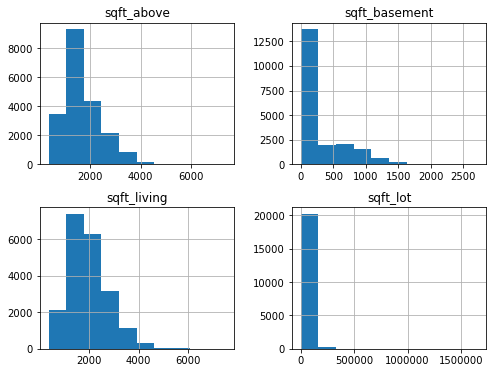

In [102]:
#running a histogram to examine the distribution of continuous columns
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
new_data[con_cols].hist(ax = ax);

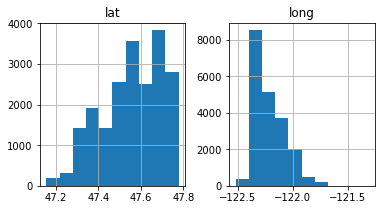

In [103]:
#running a histogram to examine the distribution of lat & long columns
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
new_data[geo_cols].hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them.

Now I want to look for high multicollinearity. I'll use a heat map of all the columns.

(16, 0)

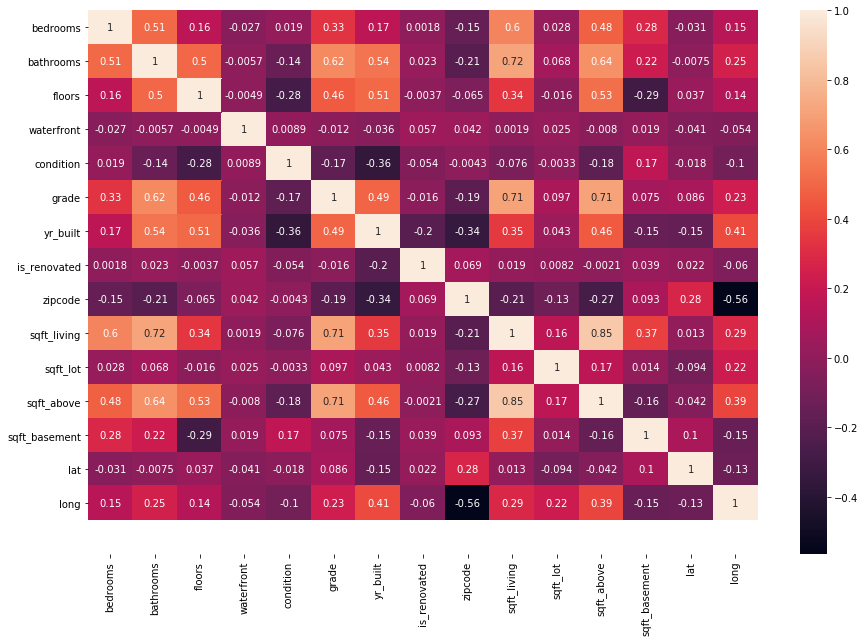

In [104]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(new_data[cat_cols + con_cols + geo_cols].corr(), annot=True)
ax.set_ylim(16,0)

I can see that some features have high correlations (above 0.75): Bathrooms + sqft, grade & sqft, sqft above and sqft living. I'll keep this in mind for feature engineering, but first I'm going to run a 'baseline' model.

## Modeling

### First 'Substandard' Model & Evaluation

Before I go into feature selection, I'll quickly run a basic model. Since CRISP-DM is an iterative process, I'll start with this and then circle back as many times as necessary to get the results I'm looking for.

Using Scikit Learn, I'm going to use a pretty standard train-test split of 70/30, scale my data, and fit it to a model. 

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, y, test_size=0.3, random_state=46)

#using a min max scaler so I can interpret coefficients by having all variables on the same scale
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
#initializing linear regression and fitting my model
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

#obtaining predicted values for both train and test data
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [107]:
#calculating residuals for analysis
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [108]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 118975.87577732376
Test Root Mean Squarred Error: 118972.7880517594
Train R2: 0.6806682255348756
Test R2: 0.685984020327101


I'm choosing to use RMSE as an indicator of how much error I have, and R2 score as an indication of how accurate my model will be. My R2 score actually isn't terrible, as it accounts for 68% of the variance in the data, and the train & test are close to each other. 

However, there is a lot of error that could affect predictions, and I'd like to improve the accuracy of the model. 

Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with transforming the continuous variables, since all look non-normal, and then address the multicollinearity. I also want to adjust location-related variables to make sure they are being usefully interpreted.

## Back to Data Preparation

My next step is to normalize continuous columns. Since this is mainly the sqft columns, I'm going to log transform them, but also eliminate some due to multicollinearity.

I saw in my heatmap that these columns had high correlations with eachother, and looking at their definitions this makes sense:

* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement

Sqft_living has high correlation with sqft_above, because sqft_living = sqft_above + sqft_basement, and not all houses have basements. 

Since sqft_living had one of the highest coefficients in my baseline model, I'm not going to use sqft_above so that we are factoring in the total size of the house, and the total size of the lot. I am going to remove the sqft_basement column and add a binary indicator, has_basement, since the total area will be captured in sqft_living.

In [109]:
new_data['sqft_living_log'] = np.log1p(data["sqft_living"])
new_data['sqft_lot_log'] = np.log1p(data["sqft_lot"])

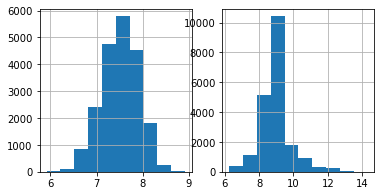

In [110]:
#previewing the distribution of the logged columns with histograms

plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 2, 1)
new_data['sqft_living_log'].hist();

ax2 = plt.subplot(1,2,2)
new_data['sqft_lot_log'].hist();

The distributions aren't perfect but they definitely look more normal. Now I'll add a basement indicator, concatenate all the X columns I'm using, and re-check correlations.

In [111]:
#new column  
new_data['has_basement'] = 0

# loop through the data and input a 1 where there is a basement
for row in new_data.index:
    if new_data['sqft_basement'][row] != 0:
        new_data['has_basement'][row] = 1

In [112]:
new_X = pd.concat([new_data[geo_cols], new_data['sqft_living_log'], new_data['sqft_lot_log'], new_data['has_basement'], new_data[cat_cols]], axis=1)

In [113]:
#checking high multicollinearity again
new_X.corr() > 0.70

,lat,long,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,is_renovated,zipcode
lat,True,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living_log,False,False,True,False,False,False,True,False,False,False,False,False,False,False
sqft_lot_log,False,False,False,True,False,False,False,False,False,False,False,False,False,False
has_basement,False,False,False,False,True,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,False,False,True,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,True,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,False,True,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False


My continuous variables look more normal and I've gotten rid of high multicollinearity except between bathrooms and sqft living.

Since I haven't addressed categorical variables I'm going to examine the location-related ones and then look at year built. 

Zipcode and lat/long are both indicators of location so I want to examine these a little closer and see if I can make them more useful, especially because I know these are being read incorrectly as numerical values. To get an idea of what the locations of these houses look like, I'm going to plot them.

In [114]:
import plotly.graph_objects as go

#create a scatter geo plot with lat/long coordinates from my dataframe

fig = go.Figure(data=go.Scattergeo(lon = new_data['long'], lat = new_data['lat'], mode = 'markers'))

fig.update_layout(
        title = 'Kings County Houses',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True))

# defining where to zoom in by taking the median of both coordinate columns making that the center
lat_foc = new_data['lat'].median()
lon_foc = new_data['long'].median()
fig.update_layout(
        geo = dict(
            projection_scale=25, #how much to zoom in 
            center=dict(lat=lat_foc, lon=lon_foc)))

fig.show()
plt.savefig('Images/house_map_scatter')

<Figure size 432x288 with 0 Axes>

It's clear from this map that there are some outlier houses that are far from the center of town. Assuming distance from the center is a factor in price, I'm going to create a column to reflect that. I'm going to use the mpu library which has a haversine distance feature that can calculate the distance between two sets of lat/long coordinates in kilometers.

In [115]:
import mpu

#creating a new column that contains the lat & long of each row as a tupule
new_data['lat_long'] = list(zip(new_data.lat, new_data.long))

# official coordinates of seattle
seattle_center = (47.6062, 122.3321)

#creating another column that will calculate the distance between each house and the center of the city

new_data['dist_from_city'] = 0

for row in new_data.index:
    house_loc = new_data['lat_long']
    new_data['dist_from_city'][row] = mpu.haversine_distance(seattle_center, house_loc[row])

Since the distribution of the distance data is non-normal, I'm going to normalize and add to my continuous variables. I'll remove the original lat & long columns, as well as zipcode since I am using distance from city center as my location variable. 

In [116]:
new_X['dist_log'] = np.log1p(new_data['dist_from_city'])

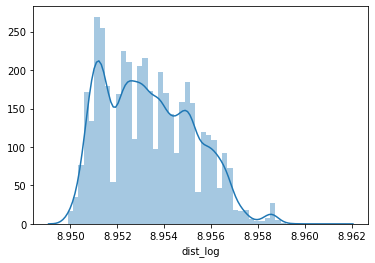

In [117]:
sns.distplot(new_X['dist_log'])

In [118]:
new_X = new_X.drop(['zipcode'], axis=1)
new_X = new_X.drop(['lat'], axis=1)
new_X = new_X.drop(['long'], axis=1)
new_X.columns

Index(['sqft_living_log', 'sqft_lot_log', 'has_basement', 'bedrooms',
       'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built',
       'is_renovated', 'dist_log'],
      dtype='object')

### Second Model

I'm going to run the model again to see if it's improved, and this time I also want to log my Y in the model knowing that its distribution is skewed. 

In [119]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=46)

#log y train and y test when running model
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#continue to use min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_2 = scaler.transform(X_train)
X_test_scaled_2 = scaler.transform(X_test)

#initiate and run model with logged and scaled data
lr_log = LinearRegression()
model2 = lr_log.fit(X_train_scaled_2, y_train_log)

In [120]:
# run predictions with logged data
y_hat_train_log = lr_log.predict(X_train_scaled_2)
y_hat_test_log = lr_log.predict(X_test_scaled_2)

#then undo the log in order to interpret scores
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)

In [121]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 126899.40810379043
Test Root Mean Squarred Error: 127320.07874993642
Train R2: 0.6367183122910214
Test R2: 0.6403746745283532


Interestingly, logging the Y, on top of the other updates, made my model slightly worse. The test data predictions also seem to be slightly higher than the training data, suggesting the model is underfit.

I'm going to take a look at the effect that different features are showing using the coefficients. I am also going to use Recursive Feature Elimination (RFE) from Scikit learn, which will help automate feature selection by training the data on each feature and analyzing its importance. 

To start off I'm going to tell it to select 10 of my 12 current features.

In [122]:
from sklearn.feature_selection import RFE

selector = RFE(linreg, n_features_to_select=10)
selector = selector.fit(new_X, y)
dict(zip(new_X.columns, selector.support_ ))

{'sqft_living_log': True,
 'sqft_lot_log': True,
 'has_basement': False,
 'bedrooms': True,
 'bathrooms': True,
 'floors': True,
 'waterfront': True,
 'condition': True,
 'grade': True,
 'yr_built': False,
 'is_renovated': True,
 'dist_log': True}

It doesn't like my binary indicator columns, has_basement and is_renovated. I'll reconsider how I could make that data more useful.

In [123]:
coefficients = linreg.coef_
coef_dict = dict(list(zip(new_X.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
floors,753916.163445
yr_built,544778.770861
bedrooms,265257.804342
is_renovated,192987.597132
sqft_lot_log,162618.583787
dist_log,161514.107895
bathrooms,97648.452333
has_basement,64862.918323
condition,28922.756074
grade,-46965.414627


Has_basement also has one of the lower coefficients, as do condition and grade, two of the rankings that came with the data. I don't have a ton of insight into how these were determined, but condition may not be really important to my business case, knowing that I am building new houses and they will be in good condition. I did some research on how the grade is determined, and based on its definition in seems like a helpful metric to keep in my data, as it refers to construction.  

*Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value*

source: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#g

Since my test data got worse in my second model, I am going to take a look at residuals and see if I can identify any trends. 

In [124]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

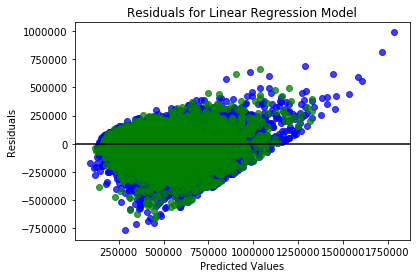

In [125]:
plt.scatter(y_hat_train, train_residuals, color='b', alpha=.75)
plt.scatter(y_hat_test, test_residuals, color='g', alpha=.75)

plt.axhline(y=0, color='black')

plt.title('Residuals for Linear Regression Model')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')
plt.show()

In [126]:
train_resid_df = X_train
train_resid_df['residuals'] = train_residuals
train_resid_df['price'] = y
train_resid_df.describe()

,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,is_renovated,dist_log,residuals,price
count,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,1.435000e+04
mean,7.515384,8.966109,0.375819,3.327038,2.055366,1.474599,0.002787,3.411498,7.541115,1970.862718,0.029477,8.953347,-14288.157706,4.795506e+05
std,0.398274,0.900078,0.484350,0.880647,0.712593,0.537174,0.052725,0.649713,1.043457,29.183441,0.169146,0.001885,126096.853130,2.105489e+05
min,5.916202,6.350886,0.000000,1.000000,0.500000,1.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,8.949884,-763041.547218,8.995000e+04
25%,7.244942,8.517393,0.000000,3.000000,1.500000,1.000000,0.000000,3.000000,7.000000,1952.000000,0.000000,8.951699,-85441.088687,3.170000e+05
50%,7.528869,8.923258,0.000000,3.000000,2.000000,1.000000,0.000000,3.000000,7.000000,1974.000000,0.000000,8.953123,-1061.152062,4.390000e+05
75%,7.800163,9.244838,1.000000,4.000000,2.500000,2.000000,0.000000,4.000000,8.000000,1996.000000,0.000000,8.954803,65524.946979,6.050000e+05
max,8.920122,13.887104,1.000000,10.000000,7.500000,3.500000,1.000000,5.000000,12.000000,2015.000000,1.000000,8.959697,988524.036171,1.150000e+06


In [127]:
#where are residuals lower than the mean, aka significantly undepredicting
train_resid_df[train_resid_df['residuals']<= -15000].describe()

,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,is_renovated,dist_log,residuals,price
count,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6.487000e+03
mean,7.531918,8.940032,0.386774,3.336673,2.080199,1.493526,0.002775,3.402497,7.608294,1970.618159,0.029752,8.953279,-120056.357140,5.941815e+05
std,0.407925,0.976077,0.487049,0.918067,0.704550,0.531643,0.052607,0.647355,1.043139,31.628620,0.169915,0.001806,93926.150844,1.997211e+05
min,5.916202,6.459904,0.000000,1.000000,0.750000,1.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,8.949884,-763041.547218,1.560000e+05
25%,7.259116,8.432289,0.000000,3.000000,1.750000,1.000000,0.000000,3.000000,7.000000,1948.000000,0.000000,8.951829,-159284.262981,4.450000e+05
50%,7.555382,8.834919,0.000000,3.000000,2.250000,1.500000,0.000000,3.000000,7.000000,1975.000000,0.000000,8.952993,-96064.880767,5.700000e+05
75%,7.832411,9.236106,1.000000,4.000000,2.500000,2.000000,0.000000,4.000000,8.000000,2001.000000,0.000000,8.954286,-51217.749641,7.250000e+05
max,8.692994,13.839294,1.000000,10.000000,5.000000,3.500000,1.000000,5.000000,11.000000,2015.000000,1.000000,8.959697,-15025.789716,1.150000e+06


In [128]:
train_resid_df[train_resid_df['residuals']>= 15000].describe()

,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,is_renovated,dist_log,residuals,price
count,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6311.000000,6.311000e+03
mean,7.523340,9.006971,0.377119,3.341943,2.058311,1.465061,0.003011,3.416099,7.539059,1970.816986,0.030898,8.953332,90781.322122,3.795098e+05
std,0.386782,0.833129,0.484704,0.849171,0.722684,0.544100,0.054791,0.646007,1.048440,26.548833,0.173056,0.001918,66893.680444,1.700474e+05
min,6.311735,6.350886,0.000000,1.000000,0.500000,1.000000,0.000000,1.000000,4.000000,1900.000000,0.000000,8.949884,15006.307678,8.995000e+04
25%,7.259116,8.674368,0.000000,3.000000,1.500000,1.000000,0.000000,3.000000,7.000000,1954.000000,0.000000,8.951440,43444.259282,2.606750e+05
50%,7.534228,8.980046,0.000000,3.000000,2.000000,1.000000,0.000000,3.000000,7.000000,1972.000000,0.000000,8.953381,74844.803746,3.400000e+05
75%,7.791936,9.263881,1.000000,4.000000,2.500000,2.000000,0.000000,4.000000,8.000000,1991.000000,0.000000,8.955061,119885.487901,4.500000e+05
max,8.920122,13.887104,1.000000,9.000000,7.500000,3.500000,1.000000,5.000000,12.000000,2015.000000,1.000000,8.958926,988524.036171,1.150000e+06


I'm not seeing any major underlying trends, except that my model is underpredicting higher priced houses (mean of 594k) and underpredicting middle priced houses (mean of 375k). I'm going to look for ways to make it more clear to identify value. 

### Third Model

Going to play around with some of the variables:

- grade has a low coefficient but seems important
- get rid of waterfront? seems innacurate
- make binary columns more useful? year updated?

In [129]:
new_data['grade'].describe()

count    20501.000000
mean         7.539096
std          1.042462
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: grade, dtype: float64

I'm not sure what the scale of housing grades are, but my data is between 3-12 with a mean of 7. I'm going to try sorting this into categories of poor, average, and high. Since there is a standard deviation of 1 I am going to make some assumptions in the ranking. 

In [130]:
new_data['grade_rank'] = 0

for row in new_data.index:
    if new_data['grade'][row] <= 5:
        new_data['grade_rank'][row] = 'poor'
    elif new_data['grade'][row] in range(6,9):
        new_data['grade_rank'][row] = 'avg'
    elif new_data['grade'][row] in range(10,12):
        new_data['grade_rank'][row] = 'high'

In [131]:
X_third = pd.concat([new_X, new_data['grade_rank']], axis=1)

In [132]:
X_third.drop(['condition'], axis=1)

,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,grade,yr_built,is_renovated,dist_log,grade_rank
0,7.074117,8.639588,0,3,1.00,1.0,0.0,7,1955,0,8.953640,avg
1,7.852050,8.887791,1,3,2.25,2.0,0.0,7,1951,1,8.950922,avg
2,6.647688,9.210440,0,2,1.00,1.0,0.0,6,1933,0,8.951311,avg
3,7.581210,8.517393,1,4,3.00,1.0,0.0,7,1965,0,8.952605,avg
4,7.427144,8.997271,0,3,2.00,1.0,0.0,8,1987,0,8.953769,avg
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,7.333676,7.031741,0,3,2.50,3.0,0.0,8,2009,0,8.950922,avg
21593,7.745436,8.668024,0,4,2.50,2.0,0.0,8,2014,0,8.952864,avg
21594,6.928538,7.208600,0,2,0.75,2.0,0.0,7,2009,0,8.952347,avg
21595,7.378384,7.778630,0,3,2.50,2.0,0.0,8,2004,0,8.954544,avg


In [133]:
grade_dummies = pd.get_dummies(new_data['grade_rank'], prefix='grade', drop_first=True)

In [134]:
X_third = pd.concat([new_X, grade_dummies], axis=1)

In [135]:
X_third = X_third.drop(['condition'], axis=1)
X_third = X_third.drop(['grade'], axis=1)
X_third

,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,yr_built,is_renovated,dist_log,grade_avg,grade_high,grade_poor
0,7.074117,8.639588,0,3,1.00,1.0,0.0,1955,0,8.953640,1,0,0
1,7.852050,8.887791,1,3,2.25,2.0,0.0,1951,1,8.950922,1,0,0
2,6.647688,9.210440,0,2,1.00,1.0,0.0,1933,0,8.951311,1,0,0
3,7.581210,8.517393,1,4,3.00,1.0,0.0,1965,0,8.952605,1,0,0
4,7.427144,8.997271,0,3,2.00,1.0,0.0,1987,0,8.953769,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,7.333676,7.031741,0,3,2.50,3.0,0.0,2009,0,8.950922,1,0,0
21593,7.745436,8.668024,0,4,2.50,2.0,0.0,2014,0,8.952864,1,0,0
21594,6.928538,7.208600,0,2,0.75,2.0,0.0,2009,0,8.952347,1,0,0
21595,7.378384,7.778630,0,3,2.50,2.0,0.0,2004,0,8.954544,1,0,0


In [151]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

regression = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv_10_results  = np.mean(cross_val_score(regression, X_third, y, cv=cv,  scoring='r2'))
cv_10_results

0.6238249222389783

In [152]:

# code to find top interactions by R^2 value here
interactions = []
combs = combinations(X_third.columns, 2)
regression = LinearRegression()

data = X_third.copy()

for i, (a, b) in enumerate(combs):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=cv))
    if score > r2_score(y_train, y_hat_train):
        interactions.append((a, b, round(score, 3)))
    if i % 50 == 0:
        print(i)
print('Top 3 interaction %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

0
50
Top 3 interaction [('dist_log', 'sqft_lot_logxdist_log', 0.628), ('sqft_living_log', 'dist_log', 0.627), ('has_basement', 'floors', 0.626)]


In [138]:
X_third['sqft_lot_logxdist_log'] = X_third['sqft_lot_log'] * X_third['dist_log']

In [139]:
X_third = X_third.drop(['waterfront'], axis=1)

,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,yr_built,is_renovated,dist_log,grade_avg,grade_high,grade_poor,sqft_lot_logxdist_log
0,7.074117,8.639588,0,3,1.00,1.0,0.0,1955,0,8.953640,1,0,0,77.355759
1,7.852050,8.887791,1,3,2.25,2.0,0.0,1951,1,8.950922,1,0,0,79.553920
2,6.647688,9.210440,0,2,1.00,1.0,0.0,1933,0,8.951311,1,0,0,82.445512
3,7.581210,8.517393,1,4,3.00,1.0,0.0,1965,0,8.952605,1,0,0,76.252860
4,7.427144,8.997271,0,3,2.00,1.0,0.0,1987,0,8.953769,1,0,0,80.559488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,7.333676,7.031741,0,3,2.50,3.0,0.0,2009,0,8.950922,1,0,0,62.940566
21593,7.745436,8.668024,0,4,2.50,2.0,0.0,2014,0,8.952864,1,0,0,77.603642
21594,6.928538,7.208600,0,2,0.75,2.0,0.0,2009,0,8.952347,1,0,0,64.533888
21595,7.378384,7.778630,0,3,2.50,2.0,0.0,2004,0,8.954544,1,0,0,69.654090


In [140]:
# new_data['yrs_since_built'] = 0

# for row in new_data.index:
#     new_data['yrs_since_built'] = 2020 - (new_data['yr_built'])

# new_X = pd.concat([new_X, new_data[['yrs_since_built']]], axis=1)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_third, y, test_size=0.3, random_state=46)

#continue to use min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_3 = scaler.transform(X_train)
X_test_scaled_3 = scaler.transform(X_test)

#initiate and run model with logged and scaled data
linreg = LinearRegression()
model3 = linreg.fit(X_train_scaled_3, y_train)

In [142]:
#obtaining predicted values for both train and test data
y_hat_train = linreg.predict(X_train_scaled_3)
y_hat_test = linreg.predict(X_test_scaled_3)

In [143]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 128770.04700917029
Test Root Mean Squarred Error: 130529.70350836216
Train R2: 0.6259290159407115
Test R2: 0.6220144705749691


R2 improved by 1 point, error slighty lower, train/test are close

In [144]:
coefficients = linreg.coef_
# coefficients = abs(coefficients)
coef_dict = dict(list(zip(X_third.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
sqft_lot_logxdist_log,5.401829e+08
sqft_living_log,8.116106e+05
bathrooms,2.403980e+05
waterfront,2.139221e+05
grade_high,8.935178e+04
floors,3.552017e+04
is_renovated,2.729488e+04
has_basement,-1.211863e+04
grade_avg,-1.462908e+05
yr_built,-1.471620e+05


### Fourth Model

In [145]:
# X_train, X_test, y_train, y_test = train_test_split(X_third, y, test_size=0.25, random_state=20)
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train_scaled_4 = scaler.transform(X_train)
# X_test_scaled_4 = scaler.transform(X_test)
# model3 = linreg.fit(X_train_scaled_4, y_train)

In [146]:
# y_hat_train = linreg.predict(X_train_scaled_4)
# y_hat_test = linreg.predict(X_test_scaled_4)

In [147]:
# print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
# print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
# print(f'Train R2: {r2_score(y_train, y_hat_train)}')
# print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 129627.98984472748
Test Root Mean Squarred Error: 128328.30244174018
Train R2: 0.621687277463318
Test R2: 0.6336947854467458


In [148]:
# coefficients = linreg.coef_
# coefficients = abs(coefficients)
# coef_dict = dict(list(zip(X_third.columns, coefficients)))
# coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
# coef_df.sort_values(by=[0], ascending=False)

,0
sqft_lot_logxdist_log,5.915874e+08
sqft_lot_log,5.909678e+08
dist_log,1.301005e+06
sqft_living_log,8.332989e+05
bathrooms,2.399403e+05
bedrooms,2.042532e+05
waterfront,1.916997e+05
grade_poor,1.546798e+05
yr_built,1.463153e+05
grade_avg,1.451208e+05


## Evaluation

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
